### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 21 декабря 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 21 декабря, -4 балла после 08:30 28 декабря, -6 баллов после 08:30 04 янва, -8 баллов после 08:30 11 января.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут

$a(x_i)$ - ответ на предыдущих шагах алгоритма.
Тогда новый алгоритм b - будет настраиваться на:

1) $$-\frac{\partial L(a, y_i)}{\partial a} = -\frac{\partial  (y_i - a(x_i)) ^ 2}{\partial a} = 2 (y_i - a(x_i))$$

2)  $$-\frac{\partial L(a, y_i)}{\partial a} =
    -\frac{\partial  (exp( -a(x_i) y_i))}{\partial a} =
    y_i * exp(-a(x_i) y_i)$$


3)
$$-\frac{\partial L(a, y_i)}{\partial a} =
    -\frac{\partial  \log (1 + exp( -a(x_i) y_i))}{\partial a} = \frac{y_i}{1 +  exp(a(x_i) y_i)}$$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [39]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='log_loss', learning_rate=0.1, n_estimators=10,
                 colsample=1, subsample=1, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.base_args = args
        self.base_kwargs = kwargs
        #print(self.base_kwargs, self.base_args)
        self.fitted_models = []
        
        if self.loss == 'mse':
            self.target_func = MyGradientBoostingClassifier.mse_target
        elif self.loss == 'exp':
            self.target_func = MyGradientBoostingClassifier.exp_target
        elif self.loss == 'log_loss':
            self.target_func = MyGradientBoostingClassifier.log_loss_target
        else:
            raise ValueError(f'{self.loss} is not available!')
            
    
    @classmethod
    def mse_target(cls, y, predict):
        return 2 * (y - predict).reshape((-1,1))
    
    @classmethod
    def exp_target(cls, y, predict):
        return y * np.exp(-predict * y)
    
    @classmethod
    def log_loss_target(cls, y, predict):
        return y / (1 + np.exp(predict * y))
    
    def generate_indexs(self, X):
        row_indexs = np.random.choice(X.shape[0], int(self.subsample * X.shape[0]))
        col_indexs = np.random.choice(X.shape[1], int(self.colsample * X.shape[1]))
        return row_indexs, col_indexs
        
    def fit(self, X, y, base_model = DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        y = np.array(y)
        self.base_model = base_model
        classes, counts = np.unique(y, return_counts = True)
        self.num_classes = len(classes)
        self.model_count = np.zeros((1, self.num_classes))#счетчик числа моделей для отделения каждого из классов
        
        y_class = [y == k for k in range(self.num_classes)]#target для отделения каждого из классов
        
        if init_model is None: 
            self.init_model = None
            self.init_predict = np.zeros((len(y),1)) #np.ones((len(y),1)) * y.mean()
        else:
            self.init_model = init_model()
            self.init_model.fit(X, y)
            print(self.init_model)
            self.init_predict = self.init_model.predict(X)
            print(self.init_predict)
        
        prev_predict = self.init_predict.reshape((-1, 1)).astype('float32') #инийиализировали y 0ми
        
        for i in range(self.n_estimators):#для каждого дерева
            k = np.random.choice(self.num_classes, 1) #выбираем класс, который будет отделять его от других
            self.model_count[0, k] += 1
            
            curr_y = y_class[k[0]].reshape((-1, 1)) #будем отдель kый класс от других
            new_model = self.base_model(*self.base_args, **self.base_kwargs)
            
            new_target = self.target_func(curr_y, prev_predict) #считаем антиградиент 
            row_indexs, col_indexs = self.generate_indexs(X)
            
            new_model.fit(X[row_indexs,:][:,col_indexs], new_target[row_indexs].ravel())
            
            self.fitted_models.append([new_model, col_indexs, k])
            
            #сделаем шаг градиентного спуска
            prev_predict += self.learning_rate * new_model.predict(X[:,col_indexs]).reshape((-1,1)) 
            
        
    def predict(self, X):
        y_pred = np.zeros((X.shape[0], self.num_classes)) #self.init_predict[:X.shape[0]]
        if self.init_model is not None:
            base_pred = self.init_model.predict_proba(X)
        
        for i in range(self.n_estimators):
            model, cols, k  = self.fitted_models[i]
            y_pred[:, k] += self.learning_rate * model.predict(X[:, cols]).reshape((-1,1))

        y_pred = np.divide(y_pred, self.model_count, where=self.model_count!=0)

        if self.init_model:
            y_pred += base_pred
        
        return np.argmax(y_pred, axis = 1)

In [97]:
my_clf = MyGradientBoostingClassifier('log_loss', 0.1, 10, 1, 1)
clf = GradientBoostingClassifier()

In [98]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [99]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [100]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [7]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [8]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [9]:
np.mean(y)

0.42194767441860465

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 22)

### График зависимости

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 5)

In [108]:
train_scores = []
test_scores = []
sklearn_test_score = []

In [109]:
range_ = np.arange(1, 100, 10)

In [110]:
for n in tqdm.tqdm(range_):
    gb = MyGradientBoostingClassifier(n_estimators=n, max_depth = 6)
    sklearn_gb = GradientBoostingClassifier(n_estimators=n, max_depth = 6)
    
    gb.fit(X_train, y_train)
    sklearn_gb.fit(X_train, y_train)
    
    test_scores.append(accuracy_score(y_test, gb.predict(X_test)))
    train_scores.append(accuracy_score(y_train, gb.predict(X_train)))
    sklearn_test_score.append(accuracy_score(y_test, sklearn_gb.predict(X_test)))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:10<00:00,  7.05s/it]


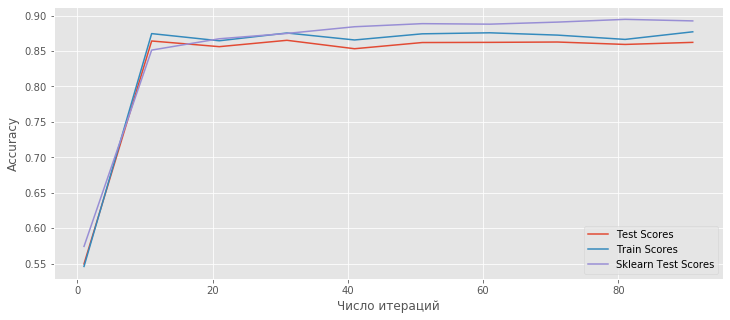

In [111]:
plt.plot(range_, test_scores, label='Test Scores')
plt.plot(range_, train_scores, label='Train Scores')
plt.plot(range_, sklearn_test_score, label='Sklearn Test Scores')
plt.legend()
plt.xlabel('Число итераций')
plt.ylabel('Accuracy')
plt.show()

In [112]:
np.max(test_scores) #Лучшее качество

0.8650678294573644

### Подбор параметров

sklearn модели судя по всему не могут иметь в конструкторе переменное число аргументов, поэтому использовать GridSearch не получится.

In [20]:
params = {'loss' :['log_loss', 'exp'],
          'n_estimators' : [5, 10, 15, 20],
          'learning_rate' : [0.1, 0.5],
          'colsample' : [0.7, 1],
          'subsample' : [0.7, 1],
          'max_depth' : [3, 4, 6]
         }

In [21]:
grid_of_params = list(ParameterGrid(params))

In [22]:
test_scores = []

In [23]:
for params in tqdm.tqdm(grid_of_params):
    my_gb = MyGradientBoostingClassifier(**params)
    my_gb.fit(X_train, y_train)
    test_scores.append(accuracy_score(y_test, my_gb.predict(X_test)))

100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [01:06<00:00,  2.89it/s]


In [24]:
grid_of_params[np.argmax(test_scores)], np.max(test_scores)

({'colsample': 0.7,
  'learning_rate': 0.1,
  'loss': 'exp',
  'max_depth': 6,
  'n_estimators': 15,
  'subsample': 0.7},
 0.8689437984496124)

In [25]:
best_params = grid_of_params[np.argmax(test_scores)]

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

### 1. BooBag

In [113]:
my_gb = MyGradientBoostingClassifier()

In [114]:
my_gb.fit(X_train, y_train, RandomForestRegressor)

In [115]:
accuracy_score(y_test, my_gb.predict(X_test))

0.8919573643410853

### 2. BagBoo

In [116]:
def get_bootstrap_samples(data, y, n_samples):
    indices = np.random.randint(0, len(data), n_samples)
    samples = data[indices]
    return samples, y[indices]

In [117]:
models = []

In [118]:
for _ in range(20):
    X_bootstrap, y_bootstrap = get_bootstrap_samples(X_train, y_train, len(X_train))
    model = MyGradientBoostingClassifier()
    model.fit(X_bootstrap, y_bootstrap)
    models.append(model)

In [119]:
prediction = [model.predict(X_test) for model in models]

In [120]:
y_pred = (np.mean(prediction, axis = 0) > 0.5).astype('int')

In [121]:
accuracy_score(y_test, y_pred)

0.8871124031007752

Качество стало чуть лучше. В случае BagBoo, например, мы получаем несколько моделей бустинга с маленьким смещением и не маленькой дисперсией. За счет бустинга мы уменьшаем эту дисперсию.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [26]:
my_gb = MyGradientBoostingClassifier()

In [27]:
from sklearn.preprocessing import StandardScaler

In [45]:
scaler = StandardScaler()

In [46]:
X_train_scale = scaler.fit_transform(X_train)

In [47]:
my_gb.fit(X_train_scale, y_train, DecisionTreeRegressor, LogisticRegression)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[0 0 0 ... 0 1 0]


In [48]:
X_test_scale = scaler.transform(X_test)

In [49]:
accuracy_score(y_test, my_gb.predict(X_test_scale))

0.8367248062015504

In [36]:
my_gb = MyGradientBoostingClassifier()

In [40]:
my_gb.fit(X_train, y_train, DecisionTreeRegressor, RandomForestClassifier)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
[0 0 0 ... 0 1 0]


In [41]:
accuracy_score(y_test, my_gb.predict(X_test))

0.8871124031007752

Качество стало чуть лучше в случае инициализации RanodmForest'ом. 
Т.к мы на первой итерации получаем более точное решение, ошибки которого нам проще исправить.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

Как обобщать градиентный бустинг на случай многоклассовой классификации. 
Судя по тому, что написано у Воронцова, на каждой итерации, дерево отделяет некоторый класс от других. 
Не очевидно почему это работает.

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

